# INFO 3401 – Class 17: Reindexing and resampling

[Brian C. Keegan, Ph.D.](http://brianckeegan.com/)  
[Assistant Professor, Department of Information Science](https://www.colorado.edu/cmci/people/information-science/brian-c-keegan)  
University of Colorado Boulder  

Copyright and distributed under an [MIT License](https://opensource.org/licenses/MIT).

## Learning Objectives
This lecture will expose you to more advanced functionality within pandas for working with temporal data.

* Strategies for handling missing data by filling, dropping, and interpolating/imputing
* Reindexing "spotty" temporal data to be continuous over a time window
* Shifting and rolling methods
* Resampling temporal data to higher or lower frequencies

## Background

We're going to work with a few different datasets in this notebook we've used before. 

* We will return to the CDC weekly counts of deaths data for [2014-2018](https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/3yf8-kanr) and [2019-present](https://data.cdc.gov/NCHS/Weekly-Counts-of-Deaths-by-State-and-Select-Causes/muzy-jte6) we explored in Class 06 on combining data. 
* We will also use the S&P500 data posted to canvas. You could also retrieve this yourself using the `yfinance` library for the "^GSPC" symbol.
* We will also use the `get_pageviews` function for retrieving pageview data from Wikipedia.

## Load libraries

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_columns = 100

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

from datetime import datetime

## Re-combine data

Read in the 2014-2018 data and inspect.

In [2]:
cdc_1418_df = pd.read_csv('Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2018.csv')
print(cdc_1418_df.shape)
cdc_1418_df.head()

(14094, 30)


,Jurisdiction of Occurrence,MMWR Year,MMWR Week,Week Ending Date,All Cause,Natural Cause,Septicemia (A40-A41),Malignant neoplasms (C00-C97),Diabetes mellitus (E10-E14),Alzheimer disease (G30),Influenza and pneumonia (J10-J18),Chronic lower respiratory diseases (J40-J47),"Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)","Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)","Diseases of heart (I00-I09,I11,I13,I20-I51)",Cerebrovascular diseases (I60-I69),flag_allcause,flag_natcause,flag_sept,flag_neopl,flag_diab,flag_alz,flag_inflpn,flag_clrd,flag_otherresp,flag_nephr,flag_otherunk,flag_hd,flag_stroke
0,Alabama,2014,1,01/04/2014,355,327,NaN,60.0,NaN,10.0,NaN,20.0,NaN,NaN,12.0,87.0,18.0,NaN,NaN,Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,NaN,NaN
1,Alabama,2014,2,01/11/2014,872,792,23.0,163.0,23.0,35.0,32.0,61.0,14.0,22.0,25.0,199.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,2014,3,01/18/2014,1044,971,21.0,209.0,34.0,31.0,33.0,77.0,19.0,24.0,19.0,242.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,2014,4,01/25/2014,1022,967,25.0,205.0,23.0,25.0,42.0,74.0,16.0,22.0,35.0,249.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,2014,5,02/01/2014,1040,953,18.0,200.0,26.0,38.0,26.0,68.0,15.0,18.0,24.0,269.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Read in the 2019-2020 data and inspect.

In [3]:
cdc_1920_df = pd.read_csv('Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2019-2020.csv')
print(cdc_1920_df.shape)
cdc_1920_df.head()

(4588, 34)


,Jurisdiction of Occurrence,MMWR Year,MMWR Week,Week Ending Date,All Cause,Natural Cause,Septicemia (A40-A41),Malignant neoplasms (C00-C97),Diabetes mellitus (E10-E14),Alzheimer disease (G30),Influenza and pneumonia (J09-J18),Chronic lower respiratory diseases (J40-J47),"Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)","Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)","Diseases of heart (I00-I09,I11,I13,I20-I51)",Cerebrovascular diseases (I60-I69),"COVID-19 (U071, Multiple Cause of Death)","COVID-19 (U071, Underlying Cause of Death)",flag_allcause,flag_natcause,flag_sept,flag_neopl,flag_diab,flag_alz,flag_inflpn,flag_clrd,flag_otherresp,flag_nephr,flag_otherunk,flag_hd,flag_stroke,flag_cov19mcod,flag_cov19ucod
0,Alabama,2019,1,1/5/2019,1077.0,993.0,30.0,198.0,22.0,60.0,21.0,63.0,14.0,21.0,27.0,261.0,53.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,2019,2,1/12/2019,1090.0,994.0,25.0,187.0,24.0,49.0,18.0,85.0,21.0,13.0,11.0,275.0,65.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,2019,3,1/19/2019,1114.0,1042.0,22.0,238.0,18.0,48.0,31.0,80.0,30.0,25.0,15.0,283.0,53.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,2019,4,1/26/2019,1063.0,994.0,21.0,165.0,22.0,50.0,22.0,113.0,14.0,25.0,23.0,279.0,56.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,2019,5,2/2/2019,1095.0,1026.0,18.0,199.0,19.0,52.0,19.0,80.0,20.0,24.0,21.0,290.0,50.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Fix the columns so they are consistent across both.

In [4]:
set(cdc_1418_df.columns) - set(cdc_1920_df.columns)

{'All  Cause', 'Influenza and pneumonia (J10-J18)'}

In [5]:
set(cdc_1920_df.columns) - set(cdc_1418_df.columns)

{'All Cause',
 'COVID-19 (U071, Multiple Cause of Death)',
 'COVID-19 (U071, Underlying Cause of Death)',
 'Influenza and pneumonia (J09-J18)',
 'flag_cov19mcod',
 'flag_cov19ucod'}

In [6]:
cdc_1418_df.rename(columns={'All  Cause':'All Cause',
                            'Influenza and pneumonia (J10-J18)':'Influenza and pneumonia'},
                   inplace=True)

cdc_1920_df.rename(columns={'Influenza and pneumonia (J09-J18)':'Influenza and pneumonia'},
                   inplace=True)

Concatenate together into a single DataFrame.

In [7]:
cdc_1420_df = pd.concat([cdc_1418_df,cdc_1920_df],ignore_index=True,sort=False)
print(cdc_1420_df.shape)
cdc_1420_df.head()

(18682, 34)


,Jurisdiction of Occurrence,MMWR Year,MMWR Week,Week Ending Date,All Cause,Natural Cause,Septicemia (A40-A41),Malignant neoplasms (C00-C97),Diabetes mellitus (E10-E14),Alzheimer disease (G30),Influenza and pneumonia,Chronic lower respiratory diseases (J40-J47),"Other diseases of respiratory system (J00-J06,J30-J39,J67,J70-J98)","Nephritis, nephrotic syndrome and nephrosis (N00-N07,N17-N19,N25-N27)","Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99)","Diseases of heart (I00-I09,I11,I13,I20-I51)",Cerebrovascular diseases (I60-I69),flag_allcause,flag_natcause,flag_sept,flag_neopl,flag_diab,flag_alz,flag_inflpn,flag_clrd,flag_otherresp,flag_nephr,flag_otherunk,flag_hd,flag_stroke,"COVID-19 (U071, Multiple Cause of Death)","COVID-19 (U071, Underlying Cause of Death)",flag_cov19mcod,flag_cov19ucod
0,Alabama,2014,1,01/04/2014,355.0,327.0,NaN,60.0,NaN,10.0,NaN,20.0,NaN,NaN,12.0,87.0,18.0,NaN,NaN,Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),NaN,Suppressed (counts 1-9),Suppressed (counts 1-9),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,2014,2,01/11/2014,872.0,792.0,23.0,163.0,23.0,35.0,32.0,61.0,14.0,22.0,25.0,199.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,2014,3,01/18/2014,1044.0,971.0,21.0,209.0,34.0,31.0,33.0,77.0,19.0,24.0,19.0,242.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,2014,4,01/25/2014,1022.0,967.0,25.0,205.0,23.0,25.0,42.0,74.0,16.0,22.0,35.0,249.0,53.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,2014,5,02/01/2014,1040.0,953.0,18.0,200.0,26.0,38.0,26.0,68.0,15.0,18.0,24.0,269.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Check min and max years are as predicted
cdc_1420_df['MMWR Year'].min(), cdc_1420_df['MMWR Year'].max()

(2014, 2020)

In [9]:
# Drop the US and NYC rows that are duplicates
cdc_1420_df = cdc_1420_df[~cdc_1420_df['Jurisdiction of Occurrence'].isin(['United States','New York City'])]
print(cdc_1420_df.shape)

(17990, 34)


In [10]:
cdc_1420_df['Week Ending Date'] = pd.to_datetime(cdc_1420_df['Week Ending Date'])

In [11]:
# Making a pivot table of flu data by state and week
cdc_1420_flu_df = pd.pivot_table(cdc_1420_df,
                                 index = 'Week Ending Date',
                                 columns = 'Jurisdiction of Occurrence',
                                 values = 'Influenza and pneumonia'
                                )

In [12]:
cdc_1420_flu_df.head()

Jurisdiction of Occurrence,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Week Ending Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-04,NaN,NaN,10.0,15.0,123.0,14.0,NaN,NaN,NaN,39.0,29.0,NaN,NaN,34.0,18.0,NaN,NaN,17.0,25.0,NaN,NaN,13.0,38.0,10.0,11.0,37.0,NaN,NaN,19.0,NaN,14.0,NaN,25.0,30.0,NaN,38.0,11.0,NaN,33.0,10.0,NaN,14.0,NaN,37.0,106.0,NaN,NaN,17.0,19.0,NaN,19.0,NaN
2014-01-11,32.0,NaN,26.0,28.0,224.0,30.0,16.0,NaN,NaN,73.0,76.0,NaN,NaN,90.0,38.0,12.0,28.0,32.0,51.0,NaN,25.0,36.0,65.0,26.0,28.0,55.0,NaN,13.0,25.0,NaN,30.0,14.0,68.0,67.0,NaN,63.0,33.0,20.0,65.0,20.0,NaN,24.0,NaN,60.0,176.0,NaN,NaN,47.0,29.0,17.0,22.0,NaN
2014-01-18,33.0,NaN,31.0,22.0,279.0,28.0,20.0,NaN,NaN,72.0,58.0,16.0,NaN,65.0,42.0,33.0,26.0,34.0,35.0,NaN,26.0,28.0,62.0,23.0,28.0,44.0,NaN,NaN,19.0,10.0,37.0,13.0,78.0,54.0,NaN,62.0,39.0,21.0,63.0,20.0,NaN,23.0,NaN,61.0,191.0,11.0,NaN,41.0,25.0,12.0,32.0,NaN
2014-01-25,42.0,NaN,45.0,23.0,245.0,28.0,12.0,NaN,NaN,74.0,51.0,10.0,NaN,63.0,31.0,18.0,17.0,28.0,39.0,NaN,23.0,31.0,52.0,16.0,29.0,26.0,NaN,NaN,28.0,NaN,32.0,20.0,72.0,66.0,NaN,68.0,23.0,21.0,73.0,14.0,NaN,27.0,NaN,67.0,130.0,14.0,NaN,47.0,21.0,13.0,29.0,NaN
2014-02-01,26.0,0.0,41.0,23.0,196.0,27.0,10.0,NaN,NaN,77.0,52.0,11.0,NaN,61.0,37.0,15.0,10.0,33.0,30.0,NaN,22.0,35.0,47.0,13.0,24.0,29.0,NaN,13.0,23.0,NaN,24.0,NaN,47.0,76.0,NaN,70.0,25.0,17.0,71.0,14.0,NaN,22.0,NaN,58.0,130.0,NaN,NaN,57.0,28.0,16.0,27.0,NaN


<AxesSubplot:xlabel='Week Ending Date'>

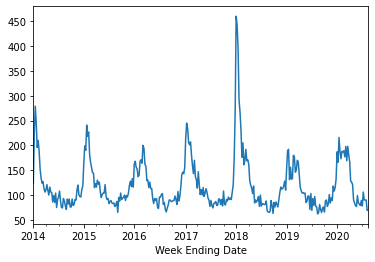

In [13]:
cdc_1420_flu_df['California'].plot()

## Rolling

A rolling average is often a better way to "smooth" out noisy data. This works by averaging observations over a window. You need to chain two methods together to return a rolling average: [`.rolling()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html) and `.mean()` but this means you can also return a rolling median, max, and other functions as well.

Make a rolling average of flu data.

In [14]:
cdc_1420_flu_df['California'].head(10)

Week Ending Date
2014-01-04    123.0
2014-01-11    224.0
2014-01-18    279.0
2014-01-25    245.0
2014-02-01    196.0
2014-02-08    210.0
2014-02-15    188.0
2014-02-22    152.0
2014-03-01    134.0
2014-03-08    124.0
Name: California, dtype: float64

In [15]:
np.mean([123,224,279,245])

217.75

In [16]:
np.mean([224,279,245,196])

236.0

In [17]:
cdc_1420_flu_df['California'].rolling(4).mean().head(10)

Week Ending Date
2014-01-04       NaN
2014-01-11       NaN
2014-01-18       NaN
2014-01-25    217.75
2014-02-01    236.00
2014-02-08    232.50
2014-02-15    209.75
2014-02-22    186.50
2014-03-01    171.00
2014-03-08    149.50
Name: California, dtype: float64

Experiment with differently-sized rolling window.

In [18]:
cdc_1420_flu_df['California'].rolling(2).mean()

Week Ending Date
2014-01-04      NaN
2014-01-11    173.5
2014-01-18    251.5
2014-01-25    262.0
2014-02-01    220.5
              ...  
2020-07-18     98.0
2020-07-25     90.0
2020-08-01     90.0
2020-08-08     79.5
2020-08-15     69.5
Name: California, Length: 346, dtype: float64

Visualize the raw data and the two different rolling windows.

<AxesSubplot:title={'center':'Weekly influenza deaths, California'}, xlabel='Week Ending Date', ylabel='Number of deaths'>

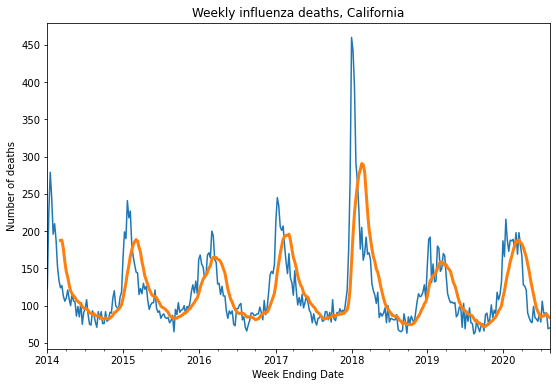

In [20]:
f,ax = plt.subplots(figsize=(9,6))

cdc_1420_flu_df['California'].plot(ax=ax,label='Original')
ax.set_ylabel('Number of deaths')
ax.set_title('Weekly influenza deaths, California')
# cdc_1420_flu_df['California'].rolling(2).mean().plot(ax=ax,label='Rolling 2')
cdc_1420_flu_df['California'].rolling(10).mean().plot(ax=ax,label='Rolling 52',lw=3)
# ax.legend(loc='center left',bbox_to_anchor=(1,.5))

Interpret.

## Reindexing

Reindexing is a method for converting data to match a new index. Reindexing works on just about any kind of data (string, categorical, continuous, *etc*.) but it is especially powerful when working with temporal data. 

Temporal data for say, the stock market, might have gaps for weekends and holidays where social media data is often available every day. Comparing both requires some way of making a Series with all dates and then filling in the missing data.

Read in the S&P500 close and volume data.

In [56]:
sp500_df = pd.read_csv('sp500_close_volume.csv',parse_dates=['Date'])
sp500_df.head()

,Date,Adj Close,Volume
0,2017-01-03,2257.830078,3770530000
1,2017-01-04,2270.750000,3764890000
2,2017-01-05,2269.000000,3761820000
3,2017-01-06,2276.979980,3339890000
4,2017-01-09,2268.899902,3217610000


In [57]:
sp500_df.loc[0,'Date']

Timestamp('2017-01-03 00:00:00')

Identify the first and last dates in the DataFrame.

In [58]:
sp500_df['Date'].min(), sp500_df['Date'].max()

(Timestamp('2017-01-03 00:00:00'), Timestamp('2020-09-24 00:00:00'))

Use [`.reindex()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reindex.html) and [`date_range()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.date_range.html) to update the DateTimeIndex to be continuous since the start.

In [64]:
sp500_daterange = pd.date_range(start = '2017-01-03',
                                end = '2020-09-24',freq='D')
sp500_daterange

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-09-15', '2020-09-16', '2020-09-17', '2020-09-18',
               '2020-09-19', '2020-09-20', '2020-09-21', '2020-09-22',
               '2020-09-23', '2020-09-24'],
              dtype='datetime64[ns]', length=1361, freq='D')

In [66]:
sp500_df.set_index('Date',inplace = True)

In [73]:
print(sp500_df.shape)
sp500_df.head()

(939, 2)


,Adj Close,Volume
Date,,
2017-01-03,2257.830078,3770530000
2017-01-04,2270.750000,3764890000
2017-01-05,2269.000000,3761820000
2017-01-06,2276.979980,3339890000
2017-01-09,2268.899902,3217610000


In [72]:
sp500_reindexed_df = sp500_df.reindex(sp500_daterange)
print(sp500_reindexed_df.shape)
sp500_reindexed_df.head(10)

(1361, 2)


,Adj Close,Volume
2017-01-03,2257.830078,3.770530e+09
2017-01-04,2270.750000,3.764890e+09
2017-01-05,2269.000000,3.761820e+09
2017-01-06,2276.979980,3.339890e+09
2017-01-07,NaN,NaN
2017-01-08,NaN,NaN
2017-01-09,2268.899902,3.217610e+09
2017-01-10,2268.899902,3.638790e+09
2017-01-11,2275.320068,3.620410e+09
2017-01-12,2270.439941,3.462130e+09


Use the `get_pageviews` function from Module Assignment 3 to retrieve the pageview data for the "[S&P 500 Index](https://en.wikipedia.org/wiki/S%26P_500_Index)" article on the English Wikipedia.

In [74]:
import requests
from urllib.parse import quote

def get_pageviews(page_title,endpoint='en.wikipedia.org',date_from='20150701',date_to='today'):
    """Takes Wikipedia page title and returns a all the various pageview records
    
    page_title - a string with the title of the page on Wikipedia
    lang - a string (typically two letter ISO 639-1 code) for the language edition,
        defaults to "en"
        datefrom - a date string in a YYYYMMDD format, defaults to 20150701 (earliest date)
        dateto - a date string in a YYYYMMDD format, defaults to today
        
    Returns:
    s - a Series indexed by date with page views as values
    """
    if date_to == 'today':
        date_to = str(datetime.today().date()).replace('-','')
        
    quoted_page_title = quote(page_title, safe='')
    date_from = datetime.strftime(pd.to_datetime(date_from),'%Y%m%d')
    date_to = datetime.strftime(pd.to_datetime(date_to),'%Y%m%d')
    
    s = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/{1}/{2}/{3}/{0}/daily/{4}/{5}".format(quoted_page_title,endpoint,'all-access','user',date_from,date_to)
    json_response = requests.get(s).json()
    
    if 'items' in json_response:
        df = pd.DataFrame(json_response['items'])
    else:
        raise KeyError('There is no "items" key in the JSON response.')
        
    df = df[['timestamp','views']]
    df['timestamp'] = pd.to_datetime(df['timestamp'],format='%Y%m%d%H')
    s = df.set_index('timestamp')['views']
        
    return s

In [75]:
# 
sp500_pv_s = get_pageviews('S&P 500 Index')
sp500_pv_s.head()

timestamp
2015-07-01    3
2015-07-02    4
2015-07-03    6
2015-07-04    2
2015-07-05    2
Name: views, dtype: int64

In [76]:
sp500_pv_s.tail()

timestamp
2020-09-25    3577
2020-09-26    2623
2020-09-27    2602
2020-09-28    3618
2020-09-29    3689
Name: views, dtype: int64

Reindex the pageview data to be identical to the S&P 500 close and volume data.

In [78]:
sp500_reindexed_pv_s = sp500_pv_s.reindex(sp500_daterange)
sp500_reindexed_pv_s

2017-01-03    2422
2017-01-04    2530
2017-01-05    2520
2017-01-06    2520
2017-01-07    1625
              ... 
2020-09-20    2780
2020-09-21    4970
2020-09-22    5034
2020-09-23    4555
2020-09-24    4465
Freq: D, Name: views, Length: 1361, dtype: int64

Combine the close and pageview data into a single DataFrame.

In [80]:
stock_and_wiki_df = pd.DataFrame({'Pageviews':sp500_reindexed_pv_s,
                                  'Stock':sp500_reindexed_df['Adj Close']})
stock_and_wiki_df

,Pageviews,Stock
2017-01-03,2422,2257.830078
2017-01-04,2530,2270.750000
2017-01-05,2520,2269.000000
2017-01-06,2520,2276.979980
2017-01-07,1625,NaN
...,...,...
2020-09-20,2780,NaN
2020-09-21,4970,3281.060059
2020-09-22,5034,3315.570068
2020-09-23,4555,3236.919922


Visualize both.

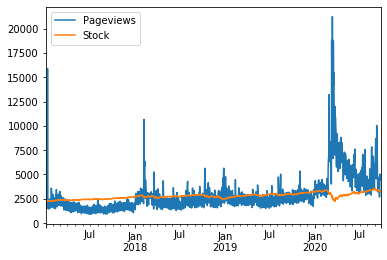

In [81]:
stock_and_wiki_df.plot()

Interpret.

## Shifting data

Sometimes it's helpful to shift or lag the data backwards or forwards in time to perform other calculations. The pandas method for this is [`.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.shift.html)

See what `.shift()` does on some of the data from before.

In [91]:
sp500_df['Adj Close'].shift(1)

Date
2017-01-03            NaN
2017-01-04    2257.830078
2017-01-05    2270.750000
2017-01-06    2269.000000
2017-01-09    2276.979980
                 ...     
2020-09-18    3357.010010
2020-09-21    3319.469971
2020-09-22    3281.060059
2020-09-23    3315.570068
2020-09-24    3236.919922
Name: Adj Close, Length: 939, dtype: float64

Shift the S&P 500 close data and compute the percentage change in close and in volume.

In [92]:
sp500_df['Shift 1'] = sp500_df['Adj Close'].shift(1)

sp500_df.head()

,Adj Close,Volume,Shift 1
Date,,,
2017-01-03,2257.830078,3770530000,NaN
2017-01-04,2270.750000,3764890000,2257.830078
2017-01-05,2269.000000,3761820000,2270.750000
2017-01-06,2276.979980,3339890000,2269.000000
2017-01-09,2268.899902,3217610000,2276.979980


In [96]:
sp500_df['diff'] = sp500_df['Adj Close'] - sp500_df['Shift 1']
sp500_df['pct_change_manual'] = (sp500_df['Adj Close'] - sp500_df['Shift 1'])/sp500_df['Adj Close']
sp500_df

,Adj Close,Volume,Shift 1,pct_change_manual,diff
Date,,,,,
2017-01-03,2257.830078,3770530000,NaN,NaN,NaN
2017-01-04,2270.750000,3764890000,2257.830078,0.005690,12.919922
2017-01-05,2269.000000,3761820000,2270.750000,-0.000771,-1.750000
2017-01-06,2276.979980,3339890000,2269.000000,0.003505,7.979980
2017-01-09,2268.899902,3217610000,2276.979980,-0.003561,-8.080078
...,...,...,...,...,...
2020-09-18,3319.469971,7068700000,3357.010010,-0.011309,-37.540039
2020-09-21,3281.060059,4828350000,3319.469971,-0.011707,-38.409912
2020-09-22,3315.570068,3963300000,3281.060059,0.010408,34.510010


Compare our method for computing change with the [`.pct_change()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.pct_change.html) method.

In [97]:
sp500_df['Adj Close'].pct_change()

Date
2017-01-03         NaN
2017-01-04    0.005722
2017-01-05   -0.000771
2017-01-06    0.003517
2017-01-09   -0.003549
                ...   
2020-09-18   -0.011183
2020-09-21   -0.011571
2020-09-22    0.010518
2020-09-23   -0.023721
2020-09-24    0.002987
Name: Adj Close, Length: 939, dtype: float64

## Missing data

When you used `pivot_table` and other data reshaping functions and methods in previous weeks, you likely encountered examples of missing data where some combination of variables had no observations and `NaN` values were introduced. Handling missing data is a frustrating but fundamental part of almost all kinds of data analyses and pandas provides some powerful methods in the form of [`.fillna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) and [`.dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html).

There's also some helper methods like [`.isna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isna.html) and [`.notna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.notna.html) for making Boolean evaluations of whether a value is missing or not in a DataFrame or Series object. Check how these helper functions work on the shifted data.

In [98]:
cdc_1420_flu_df.head()

Jurisdiction of Occurrence,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,Georgia,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
Week Ending Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-04,NaN,NaN,10.0,15.0,123.0,14.0,NaN,NaN,NaN,39.0,29.0,NaN,NaN,34.0,18.0,NaN,NaN,17.0,25.0,NaN,NaN,13.0,38.0,10.0,11.0,37.0,NaN,NaN,19.0,NaN,14.0,NaN,25.0,30.0,NaN,38.0,11.0,NaN,33.0,10.0,NaN,14.0,NaN,37.0,106.0,NaN,NaN,17.0,19.0,NaN,19.0,NaN
2014-01-11,32.0,NaN,26.0,28.0,224.0,30.0,16.0,NaN,NaN,73.0,76.0,NaN,NaN,90.0,38.0,12.0,28.0,32.0,51.0,NaN,25.0,36.0,65.0,26.0,28.0,55.0,NaN,13.0,25.0,NaN,30.0,14.0,68.0,67.0,NaN,63.0,33.0,20.0,65.0,20.0,NaN,24.0,NaN,60.0,176.0,NaN,NaN,47.0,29.0,17.0,22.0,NaN
2014-01-18,33.0,NaN,31.0,22.0,279.0,28.0,20.0,NaN,NaN,72.0,58.0,16.0,NaN,65.0,42.0,33.0,26.0,34.0,35.0,NaN,26.0,28.0,62.0,23.0,28.0,44.0,NaN,NaN,19.0,10.0,37.0,13.0,78.0,54.0,NaN,62.0,39.0,21.0,63.0,20.0,NaN,23.0,NaN,61.0,191.0,11.0,NaN,41.0,25.0,12.0,32.0,NaN
2014-01-25,42.0,NaN,45.0,23.0,245.0,28.0,12.0,NaN,NaN,74.0,51.0,10.0,NaN,63.0,31.0,18.0,17.0,28.0,39.0,NaN,23.0,31.0,52.0,16.0,29.0,26.0,NaN,NaN,28.0,NaN,32.0,20.0,72.0,66.0,NaN,68.0,23.0,21.0,73.0,14.0,NaN,27.0,NaN,67.0,130.0,14.0,NaN,47.0,21.0,13.0,29.0,NaN
2014-02-01,26.0,0.0,41.0,23.0,196.0,27.0,10.0,NaN,NaN,77.0,52.0,11.0,NaN,61.0,37.0,15.0,10.0,33.0,30.0,NaN,22.0,35.0,47.0,13.0,24.0,29.0,NaN,13.0,23.0,NaN,24.0,NaN,47.0,76.0,NaN,70.0,25.0,17.0,71.0,14.0,NaN,22.0,NaN,58.0,130.0,NaN,NaN,57.0,28.0,16.0,27.0,NaN


### `.fillna()`
`.fillna()` has a few options for dealing with missing data. The simplest is to replace all the missing values with another value; typically, 0.

In [109]:
cdc_1420_flu_df['Alaska'].fillna(0)

Week Ending Date
2014-01-04    0.0
2014-01-11    0.0
2014-01-18    0.0
2014-01-25    0.0
2014-02-01    0.0
             ... 
2020-07-18    0.0
2020-07-25    0.0
2020-08-01    0.0
2020-08-08    0.0
2020-08-15    0.0
Name: Alaska, Length: 346, dtype: float64

`.fillna()` also has some powerful methods for filling gaps in data with previous or future values commonly found in temporal data.

In [127]:
cdc_1420_flu_df['Colorado'].fillna(method='bfill').head(20)

Week Ending Date
2014-01-04    14.0
2014-01-11    30.0
2014-01-18    28.0
2014-01-25    28.0
2014-02-01    27.0
2014-02-08    24.0
2014-02-15    14.0
2014-02-22    12.0
2014-03-01    15.0
2014-03-08    13.0
2014-03-15    13.0
2014-03-22    18.0
2014-03-29    18.0
2014-04-05    12.0
2014-04-12    17.0
2014-04-19    17.0
2014-04-26    12.0
2014-05-03    12.0
2014-05-10    10.0
2014-05-17    11.0
Name: Colorado, dtype: float64

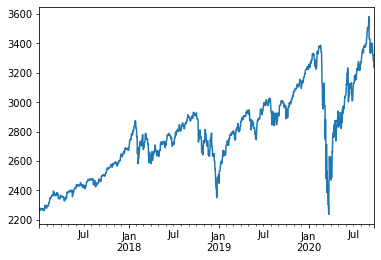

In [135]:
sp500_reindexed_df['Adj Close'].fillna(method='ffill').plot()

### `.dropna()`

You can also drop rows or columns of data that have missing values.

In [140]:
sp500_reindexed_df.dropna().head(20)

,Adj Close,Volume
2017-01-03,2257.830078,3.770530e+09
2017-01-04,2270.750000,3.764890e+09
2017-01-05,2269.000000,3.761820e+09
2017-01-06,2276.979980,3.339890e+09
2017-01-09,2268.899902,3.217610e+09
2017-01-10,2268.899902,3.638790e+09
2017-01-11,2275.320068,3.620410e+09
2017-01-12,2270.439941,3.462130e+09
2017-01-13,2274.639893,3.081270e+09
2017-01-17,2267.889893,3.584990e+09


You can also include a parameter to drop "any" rows/columns that contain missing data or rows/columns that contain "all"  missing data.

In [145]:
sp500_reindexed_df.loc[pd.Timestamp('2017-01-07'),'Volume'] = 'A LOT!'
sp500_reindexed_df.head(10)

,Adj Close,Volume
2017-01-03,2257.830078,3.77053e+09
2017-01-04,2270.750000,3.76489e+09
2017-01-05,2269.000000,3.76182e+09
2017-01-06,2276.979980,3.33989e+09
2017-01-07,NaN,A LOT!
2017-01-08,NaN,NaN
2017-01-09,2268.899902,3.21761e+09
2017-01-10,2268.899902,3.63879e+09
2017-01-11,2275.320068,3.62041e+09
2017-01-12,2270.439941,3.46213e+09


In [147]:
sp500_reindexed_df.dropna(how='all').head(10)

,Adj Close,Volume
2017-01-03,2257.830078,3.77053e+09
2017-01-04,2270.750000,3.76489e+09
2017-01-05,2269.000000,3.76182e+09
2017-01-06,2276.979980,3.33989e+09
2017-01-07,NaN,A LOT!
2017-01-09,2268.899902,3.21761e+09
2017-01-10,2268.899902,3.63879e+09
2017-01-11,2275.320068,3.62041e+09
2017-01-12,2270.439941,3.46213e+09
2017-01-13,2274.639893,3.08127e+09


## Interpolation/imputation

Interpolation and imputation are related terms for methods for filling missing data more intelligently than dropping the observation or filling all missing data with the same values. There are many, many kinds of methods and strategies for doing interpolation and imputation and it's far beyond the scope of this class to be able to cover them all. But we can start to develop your intuition for what is possible using interpolation.

Reindex the S&P 500 data to a daily frequency. Inspect to show the resulting missing data (weekends and holidays).

In [149]:
sp500_reindexed_df.head(10)

,Adj Close,Volume
2017-01-03,2257.830078,3.77053e+09
2017-01-04,2270.750000,3.76489e+09
2017-01-05,2269.000000,3.76182e+09
2017-01-06,2276.979980,3.33989e+09
2017-01-07,NaN,A LOT!
2017-01-08,NaN,NaN
2017-01-09,2268.899902,3.21761e+09
2017-01-10,2268.899902,3.63879e+09
2017-01-11,2275.320068,3.62041e+09
2017-01-12,2270.439941,3.46213e+09


Visualize the reindexed data to illustrate the gaps in the data.

In [158]:
sp500_2020_close_s = sp500_reindexed_df.loc['2020-01-01':,'Adj Close']
sp500_2020_close_s.head(10)

2020-01-01            NaN
2020-01-02    3257.850098
2020-01-03    3234.850098
2020-01-04            NaN
2020-01-05            NaN
2020-01-06    3246.280029
2020-01-07    3237.179932
2020-01-08    3253.050049
2020-01-09    3274.699951
2020-01-10    3265.350098
Freq: D, Name: Adj Close, dtype: float64

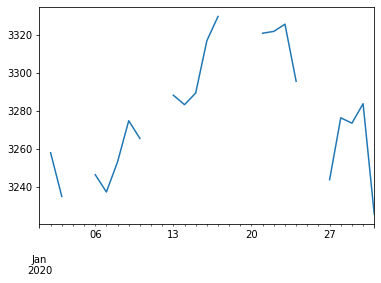

In [168]:
sp500_2020_close_s.loc[:'2020-01-31'].plot()

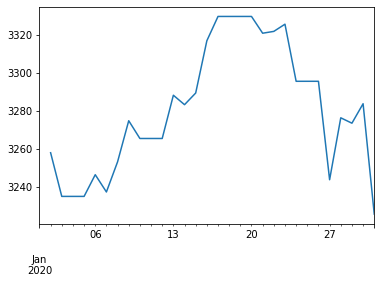

In [166]:
sp500_2020_close_s.loc[:'2020-01-31'].fillna(method='ffill').plot()

Experiment with pandas's [`.interpolate()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html) method for filling these missing values.

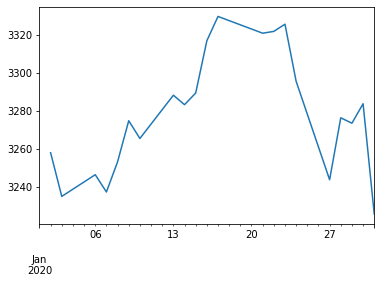

In [165]:
sp500_2020_close_s.loc[:'2020-01-31'].interpolate().plot()

Inspect a low-population state's flu death numbers from the CDC data.

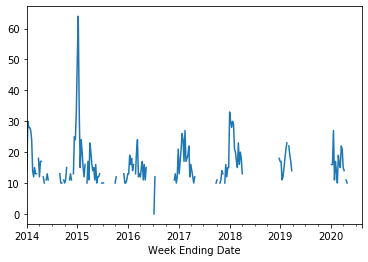

In [170]:
cdc_1420_flu_df['Colorado'].plot()

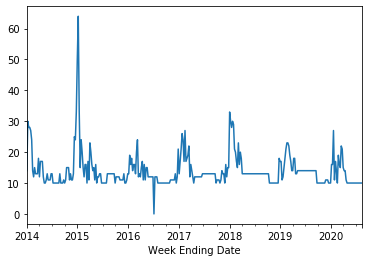

In [172]:
cdc_1420_flu_df['Colorado'].fillna(method='ffill').plot()

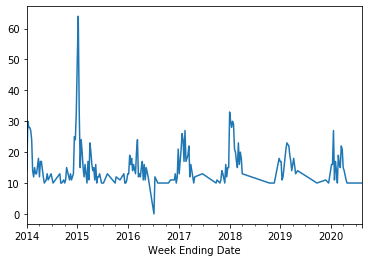

In [173]:
cdc_1420_flu_df['Colorado'].interpolate().plot()

Experiment with `.interpolate()` for different strategies for filling these missing values.

## Resampling

Resampling is a powerful method changing the frequency in temporal data. If you data has short frequency like hourly, you can "up-sample" to longer frequencies like daily or weekly. You can also "down-sample" long frequency intervals to shorter frequencies: months to weeks, hours to minutes, *etc*. 

A lot of the intuitions you've started to develop with groupby-aggregation as well as with missing data can also be applied here:

* **Up-sampling.** When you up-sample from short frequencies to longer frequencies (*e.g.*, hours to days), you are basically grouping multiple high-frequency values together to make a single lower-frequency value and need some kind of aggregation function (sum, mean, max, *etc*.). 
* **Down-sampling.** When you down-sample from long frequencies to shorter frequencies (*e.g.*, days to hours), you will have missing data and will need some kind of filling or interpolation/imputation strategy.

Use [`.resample()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.resample.html) on the combined CDC data to up-sample from the weekly frequency to a monthly frequency.

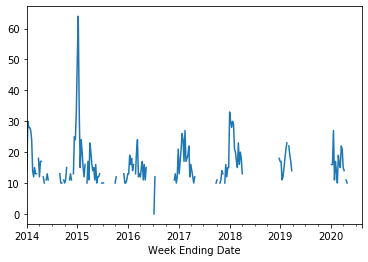

In [183]:
cdc_1420_flu_df['Colorado'].plot()

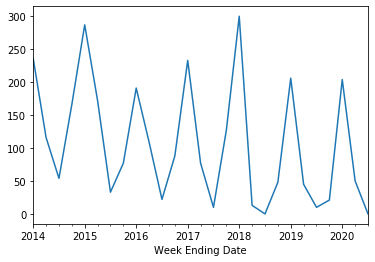

In [185]:
cdc_1420_flu_df['Colorado'].resample('').sum().plot()

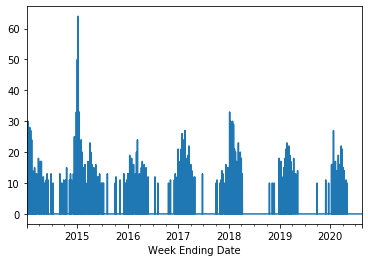

In [192]:
cdc_1420_flu_df['Colorado'].resample('1D').sum().plot()

Use the `get_pageviews` function to get the English Wikipedia pageview data for the "Influenza" article back to July 2015.

In [193]:
wiki_flu_pvs = get_pageviews('Influenza')
wiki_flu_pvs.head()

timestamp
2015-07-01    2602
2015-07-02    2405
2015-07-03    2127
2015-07-04    1882
2015-07-05    2551
Name: views, dtype: int64

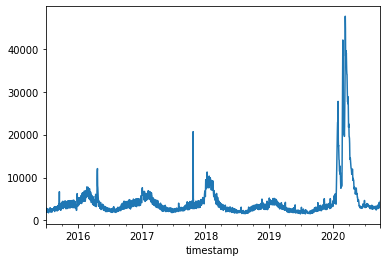

In [194]:
wiki_flu_pvs.plot()

Use `.resample()` on the Wikipedia pageview data to turn it into a weekly frequency like the CDC data.

In [216]:
wiki_flu_pvs_weekly = wiki_flu_pvs.resample('W-SAT').sum()
wiki_flu_pvs_weekly

timestamp
2015-07-04     9016
2015-07-11    17601
2015-07-18    15974
2015-07-25    16455
2015-08-01    17223
              ...  
2020-09-05    20256
2020-09-12    21713
2020-09-19    23053
2020-09-26    25773
2020-10-03    11456
Freq: W-SAT, Name: views, Length: 275, dtype: int64

Use `.resample()` on the CDC data to "down-sample" and turn it into a daily frequency like the Wikipedia data. Use some kind of interpolation method to fill in the missing data.

In [217]:
total_flu = cdc_1420_flu_df.sum(1)
total_flu

Week Ending Date
2014-01-04     825.0
2014-01-11    1784.0
2014-01-18    1817.0
2014-01-25    1668.0
2014-02-01    1537.0
               ...  
2020-07-18     610.0
2020-07-25     604.0
2020-08-01     566.0
2020-08-08     503.0
2020-08-15     352.0
Length: 346, dtype: float64

In [220]:
total_flu.index[0].weekday()

5

In [223]:
total_flu.reindex(wiki_flu_pvs_weekly.index)

timestamp
2015-07-04    693.0
2015-07-11    712.0
2015-07-18    706.0
2015-07-25    629.0
2015-08-01    575.0
              ...  
2020-09-05      NaN
2020-09-12      NaN
2020-09-19      NaN
2020-09-26      NaN
2020-10-03      NaN
Freq: W-SAT, Length: 275, dtype: float64

In [226]:
flu_df = pd.DataFrame({'Wikipedia':wiki_flu_pvs_weekly,
                       'CDC':total_flu.reindex(wiki_flu_pvs_weekly.index)
                      })

flu_df

,Wikipedia,CDC
timestamp,,
2015-07-04,9016,693.0
2015-07-11,17601,712.0
2015-07-18,15974,706.0
2015-07-25,16455,629.0
2015-08-01,17223,575.0
...,...,...
2020-09-05,20256,NaN
2020-09-12,21713,NaN
2020-09-19,23053,NaN


Plot the weekly-level CDC and Wikipedia data influenza together. Interpret.

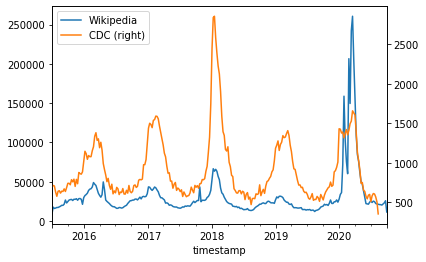

In [230]:
flu_df.plot(secondary_y='CDC')

Plot the daily-level interpolated CDC and Wikipedia influenza data together. Interpret.